✅ GPU detected and memory growth enabled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🚀 Starting Enhanced DQN Training...

📈 Episode 0: Avg Reward = 113.338, Epsilon = 1.000, Time Elapsed = 0.5s
📈 Episode 50: Avg Reward = 114.539, Epsilon = 0.010, Time Elapsed = 43.8s
📈 Episode 100: Avg Reward = 115.291, Epsilon = 0.010, Time Elapsed = 80.2s
📈 Episode 150: Avg Reward = 118.275, Epsilon = 0.010, Time Elapsed = 117.0s
📈 Episode 200: Avg Reward = 114.450, Epsilon = 0.010, Time Elapsed = 153.3s
📈 Episode 250: Avg Reward = 112.712, Epsilon = 0.010, Time Elapsed = 190.5s
📈 Episode 300: Avg Reward = 120.598, Epsilon = 0.010, Time Elapsed = 228.1s
📈 Episode 350: Avg Reward = 123.077, Epsilon = 0.010, Time Elapsed = 265.3s
📈 Episode 400: Avg Reward = 123.047, Epsilon = 0.010, Time Elapsed = 302.6s
📈 Episode 450: Avg Reward = 124.288, Epsilon = 0.010, Time Elapsed = 339.3s

✅ Training completed in 375.8 seconds

📊 Evaluation Result → Mean Reward: 135.083 ± 22.355


/tmp/ipython-input-1-3942736917.py:289: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-1-3942736917.py:289: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-1-3942736917.py:289: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: Use

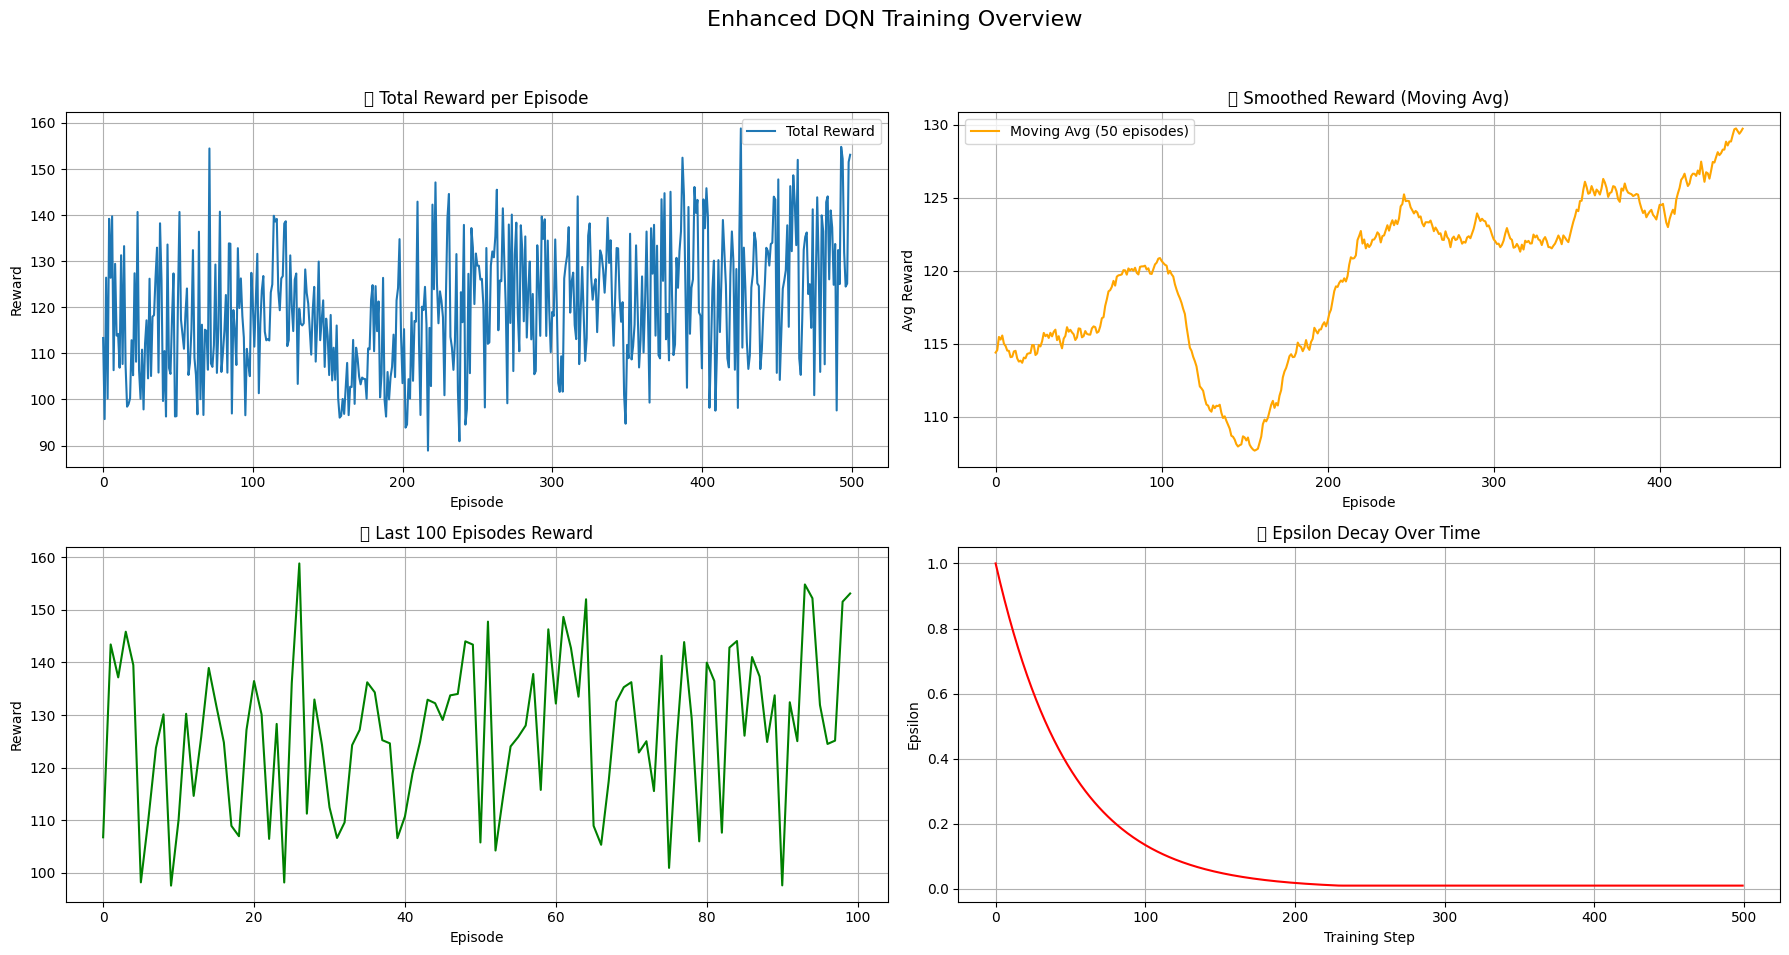

In [1]:
# Enhanced DQN with Richer Visualization and Expressive Output
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gymnasium as gym
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# GPU configuration for TensorFlow
if tf.config.experimental.list_physical_devices('GPU'):
    gpu = tf.config.experimental.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected and memory growth enabled.")
else:
    print("⚠️ No GPU found. Running on CPU.")

# ----------- Agent Class (Enhanced DQN) -----------
class EnhancedDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=50000)
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.gamma = 0.99  # Discount factor
        self.tau = 0.005   # Soft update rate for target network
        self.batch_size = 128
        self.train_freq = 4
        self.update_freq = 1000
        self.warmup_steps = 1000

        # Build the main and target Q-networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()

        # Compile model with Huber loss and gradient clipping
        self.optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate,
            clipnorm=1.0
        )
        self.q_network.compile(optimizer=self.optimizer, loss='huber', run_eagerly=False)

    def _build_model(self):
        """Builds the Q-network with dropout and normalization"""
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(self.state_size,)),
            layers.LayerNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        return model

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    @tf.function
    def predict_q_values(self, states):
        return self.q_network(states, training=False)

    @tf.function
    def predict_target_q_values(self, states):
        return self.target_network(states, training=False)

    def act(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)
        q_values = self.predict_q_values(state_tensor)
        return np.argmax(q_values.numpy()[0])

    @tf.function
    def train_step(self, states, targets):
        """Train Q-network on batch of data"""
        with tf.GradientTape() as tape:
            q_values = self.q_network(states, training=True)
            loss = keras.losses.huber(targets, q_values)
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))
        return loss

    def replay(self, step_count):
        """Sample and train on a minibatch from memory"""
        if len(self.memory) < self.warmup_steps:
            return

        batch = random.sample(self.memory, self.batch_size)
        states = np.array([e[0] for e in batch], dtype=np.float32)
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch], dtype=np.float32)
        next_states = np.array([e[3] for e in batch], dtype=np.float32)
        dones = np.array([e[4] for e in batch])

        states_tensor = tf.convert_to_tensor(states)
        next_states_tensor = tf.convert_to_tensor(next_states)

        current_q_values = self.predict_q_values(states_tensor)
        next_q_values = self.predict_q_values(next_states_tensor)
        target_q_values = self.predict_target_q_values(next_states_tensor)

        targets = current_q_values.numpy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                next_action = np.argmax(next_q_values.numpy()[i])
                targets[i][actions[i]] = rewards[i] + self.gamma * target_q_values.numpy()[i][next_action]

        targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)
        loss = self.train_step(states_tensor, targets_tensor)

        if self.epsilon > self.epsilon_min:
            decay_rate = self.epsilon_decay if step_count < 10000 else 0.9995
            self.epsilon *= decay_rate

    def update_target_network(self):
        """Soft update: slowly transfer weights to target network"""
        main_weights = self.q_network.get_weights()
        target_weights = self.target_network.get_weights()
        for i in range(len(main_weights)):
            target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_network.set_weights(target_weights)

# ----------- Custom Environment Wrapper -----------
class OptimizedPendulumEnvironment:
    def __init__(self, n_actions=7):
        self.env = gym.make('Pendulum-v1', render_mode=None)
        self.n_actions = n_actions
        self.action_space = np.linspace(-2.0, 2.0, n_actions)
        self.max_steps = 200

    def reset(self):
        state, _ = self.env.reset()
        return self._normalize_state(state)

    def step(self, discrete_action):
        continuous_action = [self.action_space[discrete_action]]
        next_state, reward, terminated, truncated, info = self.env.step(continuous_action)
        done = terminated or truncated
        return self._normalize_state(next_state), self._shape_reward(reward), done, info

    def _normalize_state(self, state):
        return state / np.array([1.0, 1.0, 8.0])

    def _shape_reward(self, reward):
        return (reward + 16.0) / 16.0

    def close(self):
        self.env.close()

# ----------- Training Function -----------
def train_enhanced_dqn(episodes=500):
    env = OptimizedPendulumEnvironment(n_actions=7)
    state_size = 3
    action_size = 7
    agent = EnhancedDQNAgent(state_size, action_size)

    scores = []
    scores_window = deque(maxlen=100)
    step_count = 0

    print("🚀 Starting Enhanced DQN Training...\n")
    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while steps < 200:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            if step_count % agent.train_freq == 0:
                agent.replay(step_count)

            if step_count % 10 == 0:
                agent.update_target_network()

            state = next_state
            total_reward += reward
            steps += 1
            step_count += 1

            if done:
                break

        scores.append(total_reward)
        scores_window.append(total_reward)

        if episode % 50 == 0:
            avg_score = np.mean(scores_window)
            elapsed_time = time.time() - start_time
            print(f"📈 Episode {episode}: Avg Reward = {avg_score:.3f}, "
                  f"Epsilon = {agent.epsilon:.3f}, Time Elapsed = {elapsed_time:.1f}s")

    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time:.1f} seconds\n")
    env.close()
    return agent, scores

# ----------- Optimizations -----------
def setup_optimizations():
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    tf.config.optimizer.set_jit(True)
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)

# ----------- Evaluation -----------
def evaluate_agent(agent, episodes=10):
    env = OptimizedPendulumEnvironment(n_actions=7)
    agent.epsilon = 0
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for _ in range(200):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break
        total_rewards.append(total_reward)

    env.close()
    return np.mean(total_rewards), np.std(total_rewards)

# ----------- Execution Starts Here -----------
if __name__ == "__main__":
    setup_optimizations()
    agent, scores = train_enhanced_dqn(episodes=500)

    mean_reward, std_reward = evaluate_agent(agent)
    print(f"📊 Evaluation Result → Mean Reward: {mean_reward:.3f} ± {std_reward:.3f}")

    # ----------- Visualization -----------
    plt.figure(figsize=(18, 10))

    # Plot 1: Total reward per episode
    plt.subplot(2, 2, 1)
    plt.plot(scores, label='Total Reward')
    plt.title('🏁 Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.legend()

    # Plot 2: Moving average
    plt.subplot(2, 2, 2)
    moving_avg = np.convolve(scores, np.ones(50)/50, mode='valid')
    plt.plot(moving_avg, color='orange', label='Moving Avg (50 episodes)')
    plt.title('📉 Smoothed Reward (Moving Avg)')
    plt.xlabel('Episode')
    plt.ylabel('Avg Reward')
    plt.grid(True)
    plt.legend()

    # Plot 3: Last 100 episodes
    plt.subplot(2, 2, 3)
    plt.plot(scores[-100:], color='green')
    plt.title('🔍 Last 100 Episodes Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)

    # Plot 4: Epsilon decay visualization
    epsilons = [max(0.01, 1.0 * (0.995 ** min(i * 4, 10000))) for i in range(len(scores))]
    plt.subplot(2, 2, 4)
    plt.plot(epsilons, color='red')
    plt.title('📉 Epsilon Decay Over Time')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.grid(True)

    plt.suptitle("Enhanced DQN Training Overview", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
